# Logo Detection - Export Model to ONNX

## Import Libraries

In [3]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator

In [4]:
root_dir = Path.cwd().parent.parent
root_dir

PosixPath('/mnt/d/Projects_D/Brand_Extractor')

## Model Data

In [5]:
model_dir = root_dir / 'training_history' / 'yolov8' / 'logos'
model_dir

PosixPath('/mnt/d/Projects_D/Brand_Extractor/training_history/yolov8/logos')

In [6]:
model_checkpoint = model_dir / 'weights' / 'best.pt'
model_checkpoint

PosixPath('/mnt/d/Projects_D/Brand_Extractor/training_history/yolov8/logos/weights/best.pt')

## Load Model

In [18]:
model = YOLO(model_checkpoint)

In [19]:
model.info()

Model summary: 295 layers, 25856899 parameters, 0 gradients, 79.1 GFLOPs


(295, 25856899, 0, 79.0656)

## Visualize Results

In [20]:
def plot_bboxes(r):
    annotator = Annotator(r.orig_img)
    boxes = r.boxes
    for box in boxes:
        b = box.xyxy[0]
        c = box.cls
        annotator.box_label(b, model.names[int(c)])
    img = annotator.result()
    return img

In [165]:
sample_image = root_dir / 'data' / 'logo_detection' / 'test' / 'images' / 'img000002_62.jpg'
sample_image

PosixPath('/mnt/d/Projects_D/Brand_Extractor/data/logo_detection/test/images/img000002_62.jpg')

In [166]:
results = model(sample_image)


image 1/1 /mnt/d/Projects_D/Brand_Extractor/data/logo_detection/test/images/img000002_62.jpg: 416x640 1 logo, 97.5ms
Speed: 2.3ms preprocess, 97.5ms inference, 2.2ms postprocess per image at shape (1, 3, 416, 640)


In [167]:
len(results)

1

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.], device='cuda:0')
conf: tensor([0.7246], device='cuda:0')
data: tensor([[225.1048, 155.0156, 475.6722, 236.2198,   0.7246,   0.0000]], device='cuda:0')
id: None
is_track: False
orig_shape: (388, 620)
shape: torch.Size([1, 6])
xywh: tensor([[350.3885, 195.6177, 250.5674,  81.2042]], device='cuda:0')
xywhn: tensor([[0.5651, 0.5042, 0.4041, 0.2093]], device='cuda:0')
xyxy: tensor([[225.1048, 155.0156, 475.6722, 236.2198]], device='cuda:0')
xyxyn: tensor([[0.3631, 0.3995, 0.7672, 0.6088]], device='cuda:0')


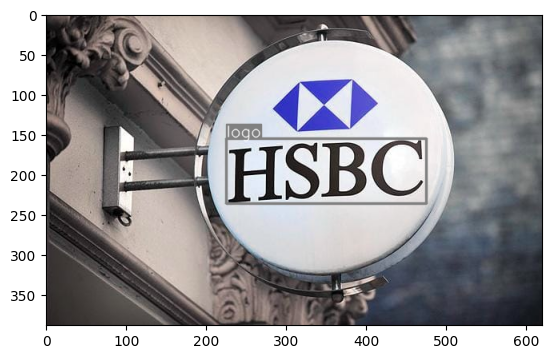

In [168]:
for result in results:
    print(result.boxes)
    img = plot_bboxes(result)
    plt.imshow(img)
    plt.show()

## Export Model to ONNX

In [169]:
onnx_model = model.export(format='onnx')

Ultralytics YOLOv8.1.47 🚀 Python-3.10.14 torch-2.2.2+cu121 CPU (11th Gen Intel Core(TM) i7-11800H 2.30GHz)

PyTorch: starting from '/mnt/d/Projects_D/Brand_Extractor/training_history/yolov8/logos/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (49.6 MB)

ONNX: starting export with onnx 1.16.0 opset 17...
ONNX: export success ✅ 2.1s, saved as '/mnt/d/Projects_D/Brand_Extractor/training_history/yolov8/logos/weights/best.onnx' (98.8 MB)

Export complete (4.0s)
Results saved to /mnt/d/Projects_D/Brand_Extractor/training_history/yolov8/logos/weights
Predict:         yolo predict task=detect model=/mnt/d/Projects_D/Brand_Extractor/training_history/yolov8/logos/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=/mnt/d/Projects_D/Brand_Extractor/training_history/yolov8/logos/weights/best.onnx imgsz=640 data=/mnt/d/Projects_D/Brand_Extractor/data/logo_detection/logo_detection.yaml  
Visualize:       https://netron.app


## ONNX Prediction

In [265]:
import onnxruntime as ort
import numpy as np
from PIL import Image
import cv2

In [266]:
img_width, img_height = Image.open(sample_image).size
img_width, img_height

(620, 388)

In [267]:
input_width, input_height = 640, 640

In [268]:
onnx_model_path = model_dir / 'weights' / 'best.onnx'
onnx_model_path

PosixPath('/mnt/d/Projects_D/Brand_Extractor/training_history/yolov8/logos/weights/best.onnx')

In [269]:
ort_session = ort.InferenceSession(str(onnx_model_path))

In [270]:
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((input_width, input_height))
    img = np.array(img).transpose(2, 0, 1)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0
    img = img.astype(np.float32)
    return img

In [271]:
def postprocess_output(outputs):
    outputs = np.transpose(np.squeeze(outputs[0]))
    rows = outputs.shape[0]

    boxes = []
    scores = []
    class_ids = []

    x_factor = img_width / input_width
    y_factor = img_height / input_height

    for i in range(rows):
        # Extract the class scores from the current row
        classes_scores = outputs[i][4:]

        # Find the maximum score among the class scores
        max_score = np.amax(classes_scores)
        
        # If the maximum score is above the confidence threshold
        if max_score >= 0.5:
            # Get the class ID with the highest score
            class_id = np.argmax(classes_scores)

            # Extract the bounding box coordinates from the current row
            x, y, w, h = outputs[i][0], outputs[i][1], outputs[i][2], outputs[i][3]

            # Calculate the scaled coordinates of the bounding box
            left = int((x - w / 2) * x_factor)
            top = int((y - h / 2) * y_factor)
            width = int(w * x_factor)
            height = int(h * y_factor)

            # Add the class ID, score, and box coordinates to the respective lists
            class_ids.append(class_id)
            scores.append(max_score)
            boxes.append([left, top, width, height])
            
    indices = cv2.dnn.NMSBoxes(boxes, scores, 0.5, 0.3)
    boxes = [boxes[i] for i in indices]
    scores = [scores[i] for i in indices]
    class_ids = [class_ids[i] for i in indices]
            
    return boxes, scores, class_ids

In [272]:
def predict_onnx(image_path):
    img = preprocess_image(image_path)
    outputs = ort_session.run(None, {'images': img})
    
    boxes, scores, class_ids = postprocess_output(outputs)
    return boxes, scores, class_ids
    

In [273]:
boxes, scores, class_ids = predict_onnx(sample_image)

In [274]:
boxes, scores, class_ids

([[224, 157, 250, 78]], [0.6730473], [0])

In [275]:
def plot_bboxes_onnx(image_path, boxes, scores, class_ids):
    img = cv2.imread(str(image_path))
    for i in range(len(boxes)):
        box = boxes[i]
        score = scores[i]
        class_id = class_ids[i]
        x, y, w, h = box
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(img, f'{model.names[class_id]}: {score:.2f}', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    return img

In [276]:
img = plot_bboxes_onnx(sample_image, boxes, scores, class_ids)

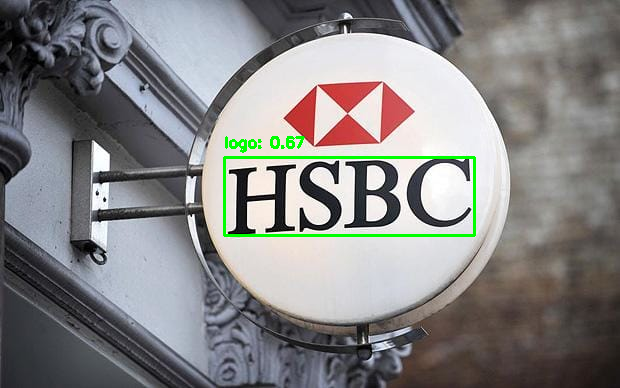

In [277]:
Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))